<a href="https://colab.research.google.com/github/keinam53/Deep_learning/blob/main/4_Regresja/1_Cena_mieszkan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem regresji - prognoza ceny mieszkań

Celem tego notebook'a jest zapoznanie się z problemami regresji. W odróżnieniu od problemów klasyfikacji, gdzie staramy się przyporządkować daną klasę, w modelach regresji przewidujemy ciągłą zmienną docelową.

1. [Import bibliotek](#a0)
2. [Załadowanie danych i wstępna eksploracja](#a1)
3. [Podział na zbiór treningowy oraz testowy](#a2)
4. [Standaryzacja danych](#a3)
5. [Budowa modelu](#a4)
6. [Trenowanie sieci](#a5)

### <a name='a0'></a> 1. Import biblotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.set_printoptions(precision=12, suppress=True, linewidth=150)
pd.options.display.float_format = '{:.6f}'.format

### <a name='a1'></a> 2. Załadowanie danych i wstępna eksploracja

In [2]:
raw_data = pd.read_csv('https://storage.googleapis.com/esmartdata-courses-files/ann-course/housing.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
data = raw_data.copy()
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000,NEAR BAY
1,-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000,NEAR BAY
2,-122.240000,37.850000,52.000000,1467.000000,190.000000,496.000000,177.000000,7.257400,352100.000000,NEAR BAY
3,-122.250000,37.850000,52.000000,1274.000000,235.000000,558.000000,219.000000,5.643100,341300.000000,NEAR BAY
4,-122.250000,37.850000,52.000000,1627.000000,280.000000,565.000000,259.000000,3.846200,342200.000000,NEAR BAY


In [4]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
data.dropna(inplace=True)
data.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20433.000000,-119.570689,2.003578,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
latitude,20433.000000,35.633221,2.136348,32.540000,33.930000,34.260000,37.720000,41.950000
housing_median_age,20433.000000,28.633094,12.591805,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,20433.000000,2636.504233,2185.269567,2.000000,1450.000000,2127.000000,3143.000000,39320.000000
total_bedrooms,20433.000000,537.870553,421.385070,1.000000,296.000000,435.000000,647.000000,6445.000000
population,20433.000000,1424.946949,1133.208490,3.000000,787.000000,1166.000000,1722.000000,35682.000000
households,20433.000000,499.433465,382.299226,1.000000,280.000000,409.000000,604.000000,6082.000000
median_income,20433.000000,3.871162,1.899291,0.499900,2.563700,3.536500,4.744000,15.000100
median_house_value,20433.000000,206864.413155,115435.667099,14999.000000,119500.000000,179700.000000,264700.000000,500001.000000


In [7]:
data.describe(include=['object']).T

,count,unique,top,freq
ocean_proximity,20433,5,<1H OCEAN,9034


In [8]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

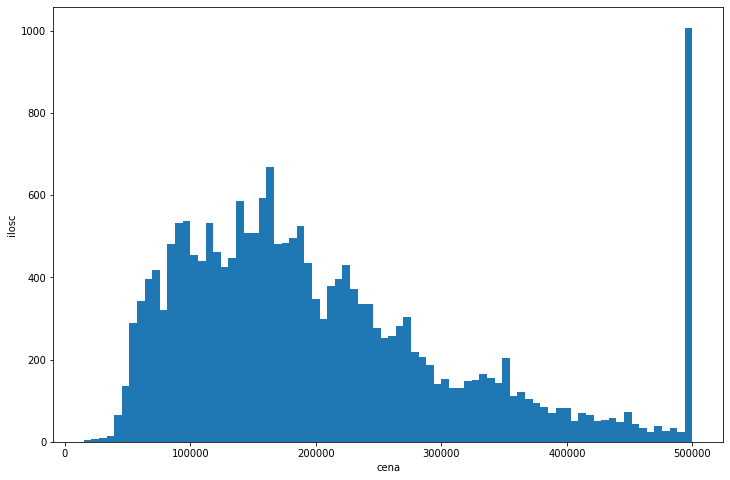

In [9]:
plt.figure(figsize=(12, 8))
plt.xlabel('cena')
plt.ylabel('ilosc')
_ = plt.hist(data['median_house_value'], bins=80)

In [10]:
data['median_house_value'].value_counts().head()

500001.000000    958
137500.000000    119
162500.000000    116
112500.000000    103
187500.000000     92
Name: median_house_value, dtype: int64

In [11]:
index_to_drop = data['median_house_value'] != 500001
data = data[index_to_drop]
data['median_house_value'].value_counts().head()

137500.000000    119
162500.000000    116
112500.000000    103
187500.000000     92
225000.000000     91
Name: median_house_value, dtype: int64

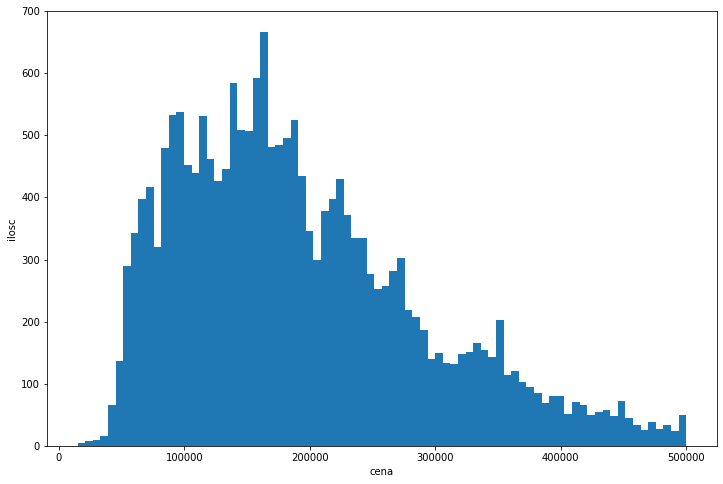

In [12]:
plt.figure(figsize=(12, 8))
plt.xlabel('cena')
plt.ylabel('ilosc')
_ = plt.hist(data['median_house_value'], bins=80)

In [13]:
data_dummies = pd.get_dummies(data, drop_first=True)
data_dummies.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000,0,0,1,0
1,-122.220000,37.860000,21.000000,7099.000000,1106.000000,2401.000000,1138.000000,8.301400,358500.000000,0,0,1,0
2,-122.240000,37.850000,52.000000,1467.000000,190.000000,496.000000,177.000000,7.257400,352100.000000,0,0,1,0
3,-122.250000,37.850000,52.000000,1274.000000,235.000000,558.000000,219.000000,5.643100,341300.000000,0,0,1,0
4,-122.250000,37.850000,52.000000,1627.000000,280.000000,565.000000,259.000000,3.846200,342200.000000,0,0,1,0


In [14]:
target = data.pop('median_house_value')
target.head()

0   452600.000000
1   358500.000000
2   352100.000000
3   341300.000000
4   342200.000000
Name: median_house_value, dtype: float64

### <a name='a2'></a> 3. Podział na zbiór treningowy oraz testowy

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_dummies, target, test_size=0.2)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (15580, 13)
X_test shape: (3895, 13)
y_train shape: (15580,)
y_test shape: (3895,)


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
X_train.shape

(15580, 13)

### <a name='a4'></a> 5. Budowa modelu

In [18]:
def build_model():
    model = Sequential()
    model.add(Dense(1024, kernel_regularizer='l2', activation='relu', input_shape=[13]))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              14336     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 604,929
Trainable params: 604,929
Non-trainable params: 0
_________________________________________________________________


### <a name='a5'></a> 6. Trenowanie sieci

In [20]:
history = model.fit(X_train, y_train, epochs=150, validation_split=0.2, batch_size=32, verbose=False)

In [23]:
metrics = pd.DataFrame(history.history)
metrics['epoch'] = history.epoch
metrics['rmse'] = np.sqrt(metrics['mse'])
metrics['val_rmse'] = np.sqrt(metrics['val_mse'])
metrics.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch,rmse,val_rmse
145,1203601.750000,293.616211,1203595.750000,453190.687500,454.249237,453184.687500,145,1097.085115,673.189934
146,970082.187500,335.480377,970076.687500,168614.640625,92.760262,168608.375000,146,984.924712,410.619501
147,1351013.875000,343.444153,1351007.625000,172272.531250,132.956863,172266.296875,147,1162.328536,415.049752
148,1252513.500000,358.022705,1252507.500000,161808.125000,83.184982,161801.906250,148,1119.154815,402.246077
149,731632.625000,240.247467,731626.250000,169521.171875,146.201233,169514.906250,149,855.351536,411.721880


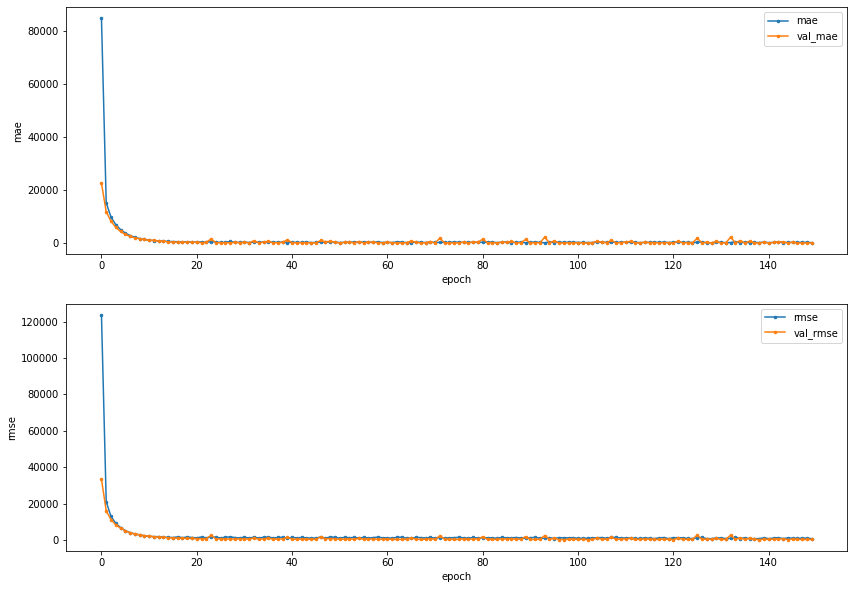

In [27]:
plt.figure(figsize=(14, 10))
plt.subplot(211)
plt.plot(metrics['epoch'], metrics['mae'], marker = '.', markersize = 5, label='mae')
plt.plot(metrics['epoch'], metrics['val_mae'], marker = '.', markersize = 5, label='val_mae')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend()
plt.subplot(212)
plt.plot(metrics['epoch'], metrics['rmse'], marker = '.', markersize = 5, label='rmse')
plt.plot(metrics['epoch'], metrics['val_rmse'], marker = '.', markersize = 5, label='val_rmse')
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.legend()
plt.show()

In [31]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=False)

print(f'loss: {loss:.4f}')
print(f'mae: {mae:.4f}')
print(f'mse: {mse:.4f}')

loss: 883402.1875
mae: 151.3358
mse: 883396.1250


In [32]:
test_predictions = model.predict(X_test).flatten()
test_predictions

array([101383.24 ,  77685.2  , 299472.6  , ..., 202545.05 ,  88460.664, 204413.   ], dtype=float32)

In [33]:
pred = pd.DataFrame(y_test)
pred['predictions'] = test_predictions
pred.head()

,median_house_value,predictions
3175,101400.000000,101383.242188
20032,77600.000000,77685.203125
10285,299600.000000,299472.593750
5613,138100.000000,138142.343750
7299,154200.000000,154294.656250


Text(0, 0.5, 'predictions')

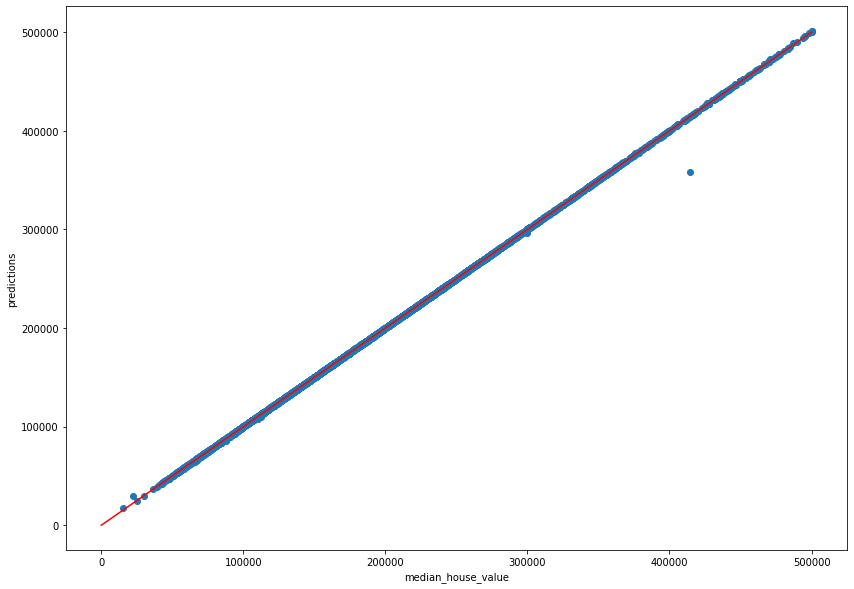

In [38]:
plt.figure(figsize=(14, 10))
plt.scatter(pred['median_house_value'], pred['predictions'])
plt.plot([0, 500000], [0, 500000], color='red')
plt.xlabel('median_house_value')
plt.ylabel('predictions')

In [41]:
pred['error'] = pred['median_house_value'] - pred['predictions']
pred.head()

,median_house_value,predictions,error
3175,101400.000000,101383.242188,16.757812
20032,77600.000000,77685.203125,-85.203125
10285,299600.000000,299472.593750,127.406250
5613,138100.000000,138142.343750,-42.343750
7299,154200.000000,154294.656250,-94.656250


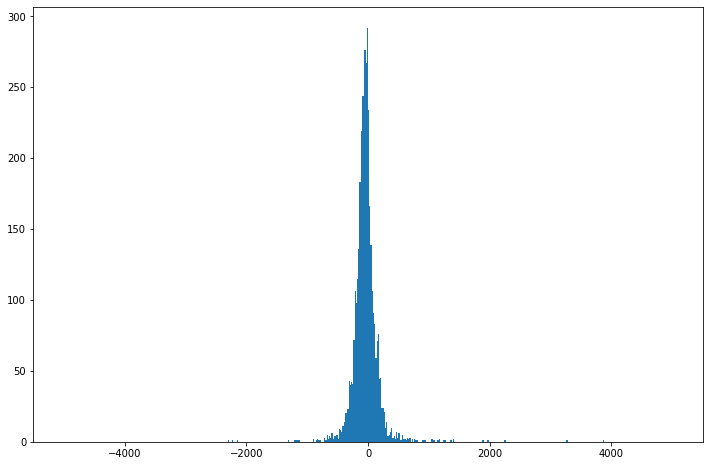

In [49]:
plt.figure(figsize=(12, 8))
_ = plt.hist(pred['error'], bins=500, range=[-5000, 5000])